## Test RRTMG column model with IATM=0 option

The IATM=0 option requires a different INPUT_RRTM format to IATM=1.  In this notebook, this option is tested by comparing the results with previous IATM=1 results.  On the way, useful routines will be stored in the `climatools` library.

In [379]:
%matplotlib inline
import os
import imp
from IPython import display

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import climatools.rrtmg.column_model as rrtmg
import climatools.units as climaunits
import climatools.aerosol.aerosol as climaaerosol

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz
import rtmtools.rrtmg.sw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse
import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse


imp.reload(aerutils)
imp.reload(aeranalyse)
imp.reload(viz)

imp.reload(rrtmg)
imp.reload(climaunits)
imp.reload(climaaerosol)

imp.reload(rrtmgwrangle)
imp.reload(rrtmganalyse)
imp.reload(cliradwrangle)
imp.reload(cliradanalyse)

<module 'rtmtools.clirad.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/clirad/sw/analyse.py'>

In [311]:
# constants

AMD = 28.9660
AMW = 18.0160
AVOGAD = 6.02214199e23

GRAV = 9.8066

In [312]:
def column_density_dryair(h2o=None, pdp=None):
    '''
    Parameters
    ----------
    h2o: H2o volume mixing ratio
    pdp: layer pressure difference [hPa, mb]
    coldry: dry air column density [molecules/cm**2]
    '''
    dims = ('time', 'lat', 'lon', '')
    amm = (1 - h2o) * AMD + h2o * AMW
    coldry = pdp * 1e3 * AVOGAD / (1e2 * GRAV * amm * (1 + h2o))
    return coldry    

In [313]:
dir_examples = '/nuwa_cluster/home/jackyu/radiation/rrtmg/SW/examples'
dir_atm1 = 'mls_71lvls_H2O'
dir_atm0 = 'mls_71lvls_H2O_iatm0'
file_atmproh5 = 'atmpro_mls70.h5'

In [314]:
os.listdir(os.path.join(dir_examples, dir_atm1))

['rrtmg_sw.py',
 'atmpro_mls70.h5',
 'rrtmg_sw.py~',
 'INPUT_RRTM',
 'rrtmg_sw_v3.9_linux_pgi',
 'OUTPUT_RRTM',
 'tape6']

In [315]:
store = pd.HDFStore(os.path.join(dir_examples, dir_atm1, file_atmproh5))
df_atmpro = store['atmpro']
store.close()

df_atmpro = df_atmpro.reset_index().drop('index', axis=1)
df_atmpro.index.names = ['ilev']
df_atmpro.head()

,altitude,pressure,temperature,H2O,CO2,O3,N2O,CO,CH4,O2
ilev,,,,,,,,,,
0,89.60800,0.00242,212.06955,6.4321,0,0,0,0,0,0
1,87.50455,0.00339,212.61195,6.4321,0,0,0,0,0,0
2,85.39563,0.00476,213.15535,6.4321,0,0,0,0,0,0
3,83.28138,0.00667,213.69980,6.4321,0,0,0,0,0,0
4,81.16173,0.00936,214.24530,6.4321,0,0,0,0,0,0


In [316]:
# convert pandas.DataFrame to xarray.Dataset
ds = xr.Dataset.from_dataframe(df_atmpro)    

In [317]:
# rename the data arrays
ds = ds.rename({'pressure': 'level_pressure',
                'altitude': 'level_altitude',
                'temperature': 'level_temperature',
                'H2O': 'level_ppmv_h2o',
                'CO2': 'level_ppmv_co2',
                'O3': 'level_ppmv_o3',
                'N2O': 'level_ppmv_n2o',
                'CO': 'level_ppmv_co',
                'CH4': 'level_ppmv_ch4',
                'O2': 'level_ppmv_o2'})

In [318]:
# compute layer values for all variables
for name in ds.data_vars:
    layer_data = .5 * (ds[name][:-1].values + ds[name][1:].values)
    ds[name.replace('level', 'layer')] = (('lev',), layer_data)

In [319]:
# increase layer and level index numbers by 1
ds.coords['lev'] = range(1, ds.dims['lev'] + 1)
ds.coords['ilev'] = range(1, ds.dims['ilev'] + 1)

In [320]:
# reindex layer and level with an additional index number
ds = ds.reindex(lev=range(ds.dims['lev'] + 1))
ds = ds.reindex(ilev=range(ds.dims['ilev'] + 1))

In [321]:
# assign top layer and leve pressures
ds['layer_pressure'][dict(lev=0)] = (.5 * ds['level_pressure']
                                     .isel(ilev=1))
ds['level_pressure'][dict(ilev=0)] = 1e-4

In [322]:
# assign top layer and level temperatures
ds['layer_temperature'][dict(lev=0)] = (ds['layer_temperature']
                                        [dict(lev=1)])
ds['level_temperature'][dict(ilev=1)] = (.5 * 
                                         sum(ds['layer_temperature']
                                             [dict(lev=[0, 1])]))
ds['level_temperature'][dict(ilev=0)] = (ds['level_temperature']
                                         [dict(ilev=1)])

In [323]:
# assign top layer molecule densities
names_molecules = ['h2o', 'co2', 'o3', 'n2o', 'co', 'ch4', 'o2']
for molecule in names_molecules:
    name_var = 'layer_ppmv_' + molecule
    ds[name_var][dict(lev=0)] = ds[name_var][dict(lev=1)]

In [324]:
# set layer and lever pressure as coordinate variables
ds = ds.set_coords(['layer_pressure', 'level_pressure'])

In [325]:
# compute layer pressure difference
ds = climaaerosol.get_pressure_difference(ds)

In [326]:
# convert molecules densities from ppmv to vmr
names_molecules = ['h2o', 'co2', 'o3', 'n2o', 'co', 'ch4', 'o2']
for molecule in names_molecules:
    name_ppmv = 'layer_ppmv_' + molecule
    name_vmr = name_ppmv.replace('ppmv', 'vmr')
    ds[name_vmr] = 1e-6 * ds[name_ppmv]


In [327]:
# drop data variables for molecule densities in ppmv
ds = ds.drop([name for name in ds.data_vars if '_ppmv_' in name])

In [328]:
# calculate column density of dry air 
coldens_dryair = column_density_dryair(h2o=ds['layer_vmr_h2o'],
                                       pdp=ds['dpressure'])
ds['layer_coldens_dryair'] = (('lev',), coldens_dryair)

h2o_lev1 = ds['layer_vmr_h2o'][dict(lev=1)]
amm = (1 - h2o_lev1) * AMD + h2o_lev1 * AMW
ds['layer_coldens_dryair'][dict(lev=0)] = (ds['level_pressure'][dict(ilev=1)] 
                                           * 1e3 * AVOGAD / 
                                           (1e2 * GRAV * amm * (1 + h2o_lev1)))

In [329]:
# convert molecule densities from vmr to column density
names_molecules = ['h2o', 'co2', 'o3', 'n2o', 'co', 'ch4', 'o2']
for name in names_molecules:
    ds['layer_coldens_' + name] = (ds['layer_vmr_' + name] 
                                   * ds['layer_coldens_dryair'])

In [330]:
# drop data variables for molecule densities in vmr
ds = ds.drop([name for name in ds.data_vars if '_vmr_' in name])

In [331]:
ds['juldat'] = ((), 0., {'long_name': 'Julian day associated with calculation', 
                         'units': 'days'})

ds['sza'] = ((), 60, {'long_name': 'solar zenith angle in degrees',
                      'units': 'degrees'})

In [352]:
os.chdir(os.path.join(dir_examples, dir_atm0))

rrtmg.write_input_rrtm(ds=ds, aerosol=False, iatm=0)

In [353]:
!ls

INPUT_RRTM  OUTPUT_RRTM  rrtmg.exe


### Plot to see if results are reasonable

In [381]:
pnl_rrtmg_iatm0 = rrtmgwrangle.\
                  OUTPUT_RRTM_to_pandasPanel(readfrom='OUTPUT_RRTM',
                                             cooling_rate=False,
                                             signed_fluxes=True)

In [382]:
pnl_rrtmg_iatm1 = rrtmgwrangle.\
                  OUTPUT_RRTM_to_pandasPanel(readfrom=os.path.join(dir_examples,
                                                                   dir_atm1,
                                                                   'OUTPUT_RRTM'),
                                             cooling_rate=False,
                                             signed_fluxes=True)

In [376]:
# Load CLIRAD results
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/SW/examples/mls75_H2O/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.\
             OUTPUT_CLIRAD_to_PandasPanel(readfrom=pathout_clirad, 
                                          signed_fluxes=True)

In [386]:
name_molecule = r'$H_{2}O$'

def plot_total_heating_rates(infos_wavenumber = None, infos_spectralband = None):
    global name_molecule, xlim_linear
    atm_levels = [70, 30, 0]

    if infos_wavenumber:
        (names_wavenumber, colours_wavenumber, 
         linestyles_wavenumber, pnls_wavenumber) = map(list, zip(*infos_wavenumber))
    
        dfs_wavenumber = [aeranalyse.\
                          sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 1000, V2 = 25000) \
                          for pnl in pnls_wavenumber]
    else:
        (dfs_wavenumber, names_wavenumber, 
         colours_wavenumber, linestyles_wavenumber) = ([], [], [], [])
        
    if infos_spectralband:
        (names_spectralband, colours_spectralband, 
         linestyles_spectralband, pnls_spectralband) = map(list, zip(*infos_spectralband))
    
        dfs_spectralband = [cliradanalyse.\
                            sum_OUTPUT_CLIRAD_over_wbands(pnl, 
                                                          wbands = range(1, 11))
                            for pnl in pnls_spectralband]
    else:
        (dfs_spectralband, names_spectralband,
         colours_spectralband, linestyles_spectralband) = ([], [], [], [])

    dfs = dfs_wavenumber + dfs_spectralband
    names = names_wavenumber + names_spectralband
    colours = colours_wavenumber + colours_spectralband
    linestyles = linestyles_wavenumber + linestyles_spectralband    
    
    dfs_atm_levels = [df.loc[atm_levels, :] for df in dfs]
    
    viz.tabulate_difference(dfs = dfs_atm_levels, 
                            names = names,
                            title = 'Total heating rate. {}'.format(name_molecule))    
    
    max_cr = max([df['heating_rate'].max() for df in dfs])
    
    viz.plot_pres_vs_hrcr(dfs = dfs_wavenumber + dfs_spectralband,
                          names = names_wavenumber + names_spectralband,
                          linestyles = linestyles_wavenumber + linestyles_spectralband, 
                          colours = colours_wavenumber + colours_spectralband,
                          title = 'Total heating rate. {}'.format(name_molecule),
                          cooling_rate = False,
                          xlim_linear = None,
                          xlim_log = None)
    
    display.display(plt.gcf()); plt.close()


Total heating rate. $H_{2}O$

RRTMG iatm0
    pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70     0.002  -0.0002             0      592.7477   592.7477  592.7475   
30   299.800  -0.0001             0      581.9248   581.9248  581.9247   
0   1013.000   0.0000             0      477.2950   477.2950  477.2950   

    heating_rate  
70       0.57144  
30       1.01014  
0        1.22188  

RRTMG iatm1
      pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70     0.00242  -0.0002             0      592.7477   592.7477  592.7475   
30   299.70000  -0.0001             0      582.0274   582.0274  582.0273   
0   1013.00000   0.0000             0      477.3102   477.3102  477.3102   

    heating_rate  
70       0.00000  
30       1.01312  
0        1.22063  

RRTMG iatm0 - RRTMG iatm1
    pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
70  -0.00042        0             0        0.0000     0.0000    0.0000   
30   0.10000   

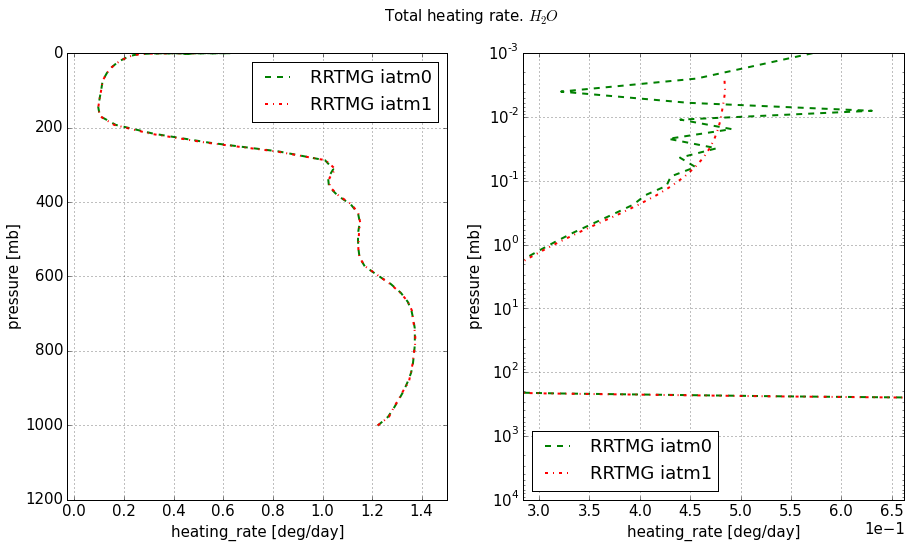

In [387]:
plot_total_heating_rates(infos_wavenumber=[('RRTMG iatm0', 'g', '--', pnl_rrtmg_iatm0),
                                           ('RRTMG iatm1', 'r', '-.', pnl_rrtmg_iatm1)])#,
#                         infos_spectralband=[('CLIRAD', 'b', '--', pnl_clirad)])

### Conclusion

Following the steps in this notebook, it is possible to load the atmosphere profile from HDF5 file and convert it to a valid IN_RRTM with IATM=0.  This means that the LBLRTM ray-tracing program RRTATM can be skipped in running RRTMG-SW column model.

In [388]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')